In [ ]:
!wget 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip' 

In [ ]:
!unzip '/content/cats_and_dogs_filtered.zip' -d '/content/data'

In [4]:
import tensorflow as tf
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [34]:
data_dir = 'data'

In [35]:
data = tf.keras.utils.image_dataset_from_directory('data/cats_and_dogs_filtered/train')
val = tf.keras.utils.image_dataset_from_directory('data/cats_and_dogs_filtered/validation')

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [36]:
data = data.map(lambda x,y: (x/255, y))
val = val.map(lambda x,y: (x/255, y))

In [37]:
train_size = int(len(data)*.9)
test_size = int(len(data)*.1)

In [38]:
data = data.map(lambda x,y: (tf.image.resize(x, (128, 128)), y))
val = val.map(lambda x,y: (tf.image.resize(x, (128, 128)), y))

In [39]:
train = data.take(train_size)
test = data.skip(train_size).take(test_size)

In [40]:
IMG_SHAPE = (128, 128, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False 

In [41]:
model = tf.keras.Sequential([base_model,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dense(1, activation = 'sigmoid')])
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0003),
              loss = 'binary_crossentropy',
              metrics =['accuracy'])

In [42]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs= 30, validation_data=val, callbacks=[tensorboard_callback])

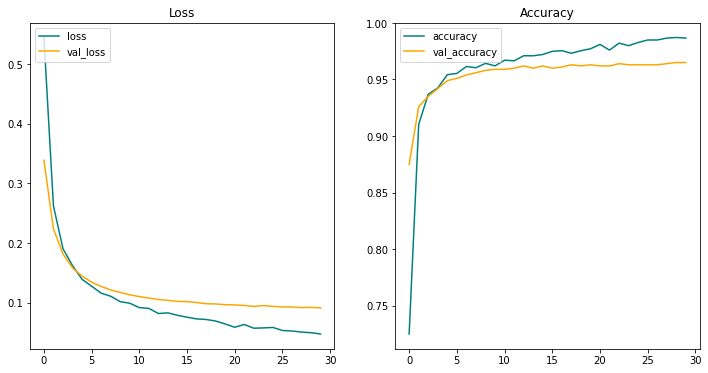

In [44]:
fig, ax = plt.subplots(ncols = 2, figsize = (12, 6))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val_loss')

ax[1].plot(hist.history['accuracy'], color='teal', label='accuracy')
ax[1].plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')

ax[0].title.set_text('Loss')
ax[1].title.set_text('Accuracy')

ax[0].legend(loc="upper left")
ax[1].legend(loc="upper left")

Реализован transfer learning модели MobileNetV2. Точность на валидационных данных составилa в районе 96%. Перейдем к fine tuning, разморозив слои базовой модели.

In [45]:
base_model.trainable = True
print("Количество слоев в базовой модели: ", len(base_model.layers))

Количество слоев в базовой модели:  154


In [46]:
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0003),
              loss = 'binary_crossentropy',
              metrics =['accuracy'])

In [48]:
logdir_ft='logs_ft'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir_ft)

In [ ]:
hist = model.fit(train, epochs= 10, validation_data=val, callbacks=[tensorboard_callback])

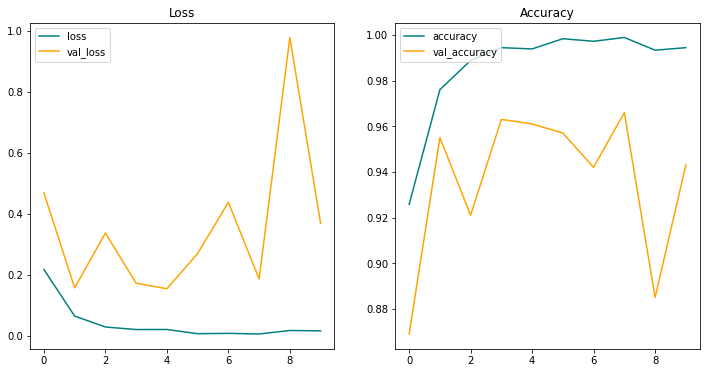

In [50]:
fig, ax = plt.subplots(ncols = 2, figsize = (12, 6))

ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val_loss')

ax[1].plot(hist.history['accuracy'], color='teal', label='accuracy')
ax[1].plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')

ax[0].title.set_text('Loss')
ax[1].title.set_text('Accuracy')

ax[0].legend(loc="upper left")
ax[1].legend(loc="upper left")

После обучения точность увеличилась, но видны небольшие признаки переобучения на тренировочных данных (точность 99,8%). Посмотрим реальный и предсказанный класс для изображений.

In [ ]:
def show_catsdogs(images, labels, predicted_labels=None):
    names = {0: "Cat", 1: "Dog"}
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[labels[i]]}. Pred: {names[int(predicted_labels[i])]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")

In [65]:
sample = test.as_numpy_iterator()
sample1 = sample.next()

In [66]:
sample_validation_images,sample_validation_labels = sample1

In [67]:
predicted = model.predict(test)

In [68]:
predicted_label = list(np.where(predicted > 0.5, 1,0))

In [ ]:
show_catsdogs(sample_validation_images, sample_validation_labels, predicted_label)